# Encoding of Categorical Features with Many Values

Categorical features are a common occurrence in many datasets. However, they can pose a challenge when it comes to modeling, especially when there are many unique values. This notebook explores different techniques for encoding categorical features with many values, including frequency-based encoding, target-based encoding, clustering similar categories, and hash encoding.


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.feature_extraction import FeatureHasher

# Create synthetic dataset
np.random.seed(42)
n_samples = 5000
categories = [f'cat_{i}' for i in range(1, 101)]  # 100 unique categories
data = {
    'category': np.random.choice(categories, n_samples),
    'numeric_feature': np.random.randn(n_samples),
    'target': np.random.randint(0, 2, n_samples)
}
df = pd.DataFrame(data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=42)

# 1. Frequency-Based Encoding
threshold = 0.01  # 1% frequency
value_counts = X_train['category'].value_counts(normalize=True)
top_categories = value_counts[value_counts > threshold].index
X_train['category_grouped'] = X_train['category'].apply(lambda x: x if x in top_categories else 'Other')
X_test['category_grouped'] = X_test['category'].apply(lambda x: x if x in top_categories else 'Other')

# 2. Target-Based Encoding (Mean-Encoding)
encoder = TargetEncoder()
encoder.fit(X_train['category'], y_train)
X_train['category_encoded'] = encoder.transform(X_train['category']).values
X_test['category_encoded'] = encoder.transform(X_test['category']).values

# 3. Clustering Similar Categories 
# For demonstration, let's assume categories with similar suffixes are similar
X_train['category_clustered'] = X_train['category'].apply(lambda x: x.split('_')[1])
X_test['category_clustered'] = X_test['category'].apply(lambda x: x.split('_')[1])


# 4. Hash Encoding
hasher = FeatureHasher(n_features=10, input_type='string')
hashed_features_train = hasher.transform(X_train['category'].apply(lambda x: [x]))
hashed_features_test = hasher.transform(X_test['category'].apply(lambda x: [x]))
hashed_df_train = pd.DataFrame(hashed_features_train.toarray(), columns=[f'hash_{i}' for i in range(10)])
hashed_df_test = pd.DataFrame(hashed_features_test.toarray(), columns=[f'hash_{i}' for i in range(10)])

# Add hashed features to original data
X_train = pd.concat([X_train, hashed_df_train], axis=1)
X_test = pd.concat([X_test, hashed_df_test], axis=1)


# Display the transformed datasets
print("Frequency-Based Encoding:\n", X_train[['category', 'category_grouped']].head())
print("\nTarget-Based Encoding:\n", X_train[['category', 'category_encoded']].head())
print("\nClustering Similar Categories:\n", X_train[['category', 'category_clustered']].head())
print("\nHash Encoding:\n", X_train[['category'] + [f'hash_{i}' for i in range(10)]].head())

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4227 to 860
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   category            4000 non-null   object 
 1   numeric_feature     4000 non-null   float64
 2   category_grouped    4000 non-null   object 
 3   category_encoded    4000 non-null   float64
 4   category_clustered  4000 non-null   object 
dtypes: float64(2), object(3)
memory usage: 187.5+ KB
Frequency-Based Encoding:
      category category_grouped
4227   cat_76            Other
4676   cat_43            Other
800    cat_27            Other
3671   cat_51           cat_51
4193   cat_47           cat_47

Target-Based Encoding:
      category  category_encoded
4227   cat_76          0.512932
4676   cat_43          0.502257
800    cat_27          0.418742
3671   cat_51          0.426910
4193   cat_47          0.535024

Clustering Similar Categories:
      category category_clustered
4227

# Collisions in Hash-encoding

with 100 categories mapped to 10 features, there will very likely be collisions. 
- Each category needs a unique representation
- With 10 features, each having 3 possible values (-1, 0, 1)
- Maximum unique combinations = 3^10 ≈ 59,049
- But most combinations will be sparse (mostly zeros)
- Actual unique patterns much fewer than 59,049
- If the sparse vectors were well-distributed and the hashing mechanism perfectly balanced, the collisions might not always happen—but this scenario is extremely unlikely.

Let's demonstrate this:

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import FeatureHasher

# Create dataset with 100 categories
np.random.seed(42)
data = {
    'category': [f'cat_{i}' for i in range(100)]
}
df = pd.DataFrame(data)

# Hash to 10 features
hasher = FeatureHasher(n_features=10, input_type='string')
hashed_features = hasher.transform(df['category'].apply(lambda x: [x]))
hashed_df = pd.DataFrame(
    hashed_features.toarray(), 
    columns=[f'hash_{i}' for i in range(10)]
)

# Check for unique representations
unique_patterns = hashed_df.drop_duplicates()
print(f"Number of categories: {len(df)}")
print(f"Number of unique hash patterns: {len(unique_patterns)}")

# Show some examples of collisions
print("\nExample of collisions:")
for pattern in hashed_df.values[:5]:
    matching_cats = df[hashed_df.apply(lambda x: all(x == pattern), axis=1)]['category']
    if len(matching_cats) > 1:
        print(f"\nCategories sharing pattern {pattern}:")
        print(matching_cats.values)

Number of categories: 100
Number of unique hash patterns: 20

Example of collisions:

Categories sharing pattern [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]:
['cat_0' 'cat_1' 'cat_54' 'cat_84']

Categories sharing pattern [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]:
['cat_0' 'cat_1' 'cat_54' 'cat_84']

Categories sharing pattern [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]:
['cat_2' 'cat_3' 'cat_66' 'cat_95']

Categories sharing pattern [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]:
['cat_2' 'cat_3' 'cat_66' 'cat_95']

Categories sharing pattern [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]:
['cat_4' 'cat_8' 'cat_19' 'cat_32' 'cat_41' 'cat_57' 'cat_71' 'cat_78']


# Target encoding and data leakage

Target encoding can lead to data leakage because it uses target information to encode categories. 

Solutions:
- Split data before encoding
- Use cross-validation for encoding for more robust estimates
- Consider smoothing parameters

In [5]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Create sample data
np.random.seed(42)
n_samples = 1000
data = {
    'category': np.random.choice(['A', 'B', 'C', 'D', 'E'], n_samples),
    'target': np.random.randint(0, 2, n_samples)
}
df = pd.DataFrame(data)

# Bad Practice (Data Leakage)
encoder_bad = TargetEncoder()
df['encoded_bad'] = encoder_bad.fit_transform(df['category'], df['target'])

# Good Practice 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df[['category']], df['target'], test_size=0.2, random_state=42
)

encoder_good = TargetEncoder()
encoder_good.fit(X_train['category'], y_train)
X_train['encoded'] = encoder_good.transform(X_train['category']).values
X_test['encoded'] = encoder_good.transform(X_test['category']).values

# Good Practice 2: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df['encoded_cv'] = np.nan

for train_idx, val_idx in kf.split(df):
    # Get train and validation sets
    encoder = TargetEncoder()
    
    # Fit the encoder using training fold
    encoder.fit(
        df.iloc[train_idx]['category'], 
        df.iloc[train_idx]['target']
    )
    
    # Transform the training and validation fold
    df.loc[train_idx, 'encoded_cv'] = encoder.transform(df.iloc[train_idx]['category']).values
    df.loc[val_idx, 'encoded_cv'] = encoder.transform(df.iloc[val_idx]['category']).values

print("\nOriginal vs CV-encoded values:")
print(df[['category', 'target', 'encoded_cv']].head(10))

# Show average encoding per category
print("\nAverage encoding per category:")
print(df.groupby('category')['encoded_cv'].mean())

print("Bad Practice (with leakage):\n", df[['category', 'target', 'encoded_bad']].head())
print("\nGood Practice (train set):\n", X_train[['category', 'encoded']].head())
print("\nGood Practice (CV):\n", df[['category', 'target', 'encoded_cv']].head())


Original vs CV-encoded values:
  category  target  encoded_cv
0        D       1    0.466667
1        E       1    0.503226
2        C       1    0.532895
3        E       1    0.503226
4        E       1    0.503226
5        B       0    0.428572
6        C       1    0.532895
7        C       0    0.532895
8        C       1    0.532895
9        E       0    0.503226

Average encoding per category:
category
A    0.454023
B    0.428572
C    0.532895
D    0.466667
E    0.503226
Name: encoded_cv, dtype: float64
Bad Practice (with leakage):
   category  target  encoded_bad
0        D       1     0.475728
1        E       1     0.504902
2        C       1     0.536842
3        E       1     0.504902
4        E       1     0.504902

Good Practice (train set):
     category   encoded
29         D  0.461538
535        E  0.552941
695        B  0.468532
557        E  0.552941
836        B  0.468532

Good Practice (CV):
   category  target  encoded_cv
0        D       1    0.466667
1        E

##  CV vs simple mean of means

1. Independence:  
* CV encoding: Each sample's encoding is independent of its own target value   
* Mean of means: Every sample influences all encodings     

2. Leakage:
* CV encoding: No leakage because samples are encoded with means calculated without them
* Mean of means: Contains information from all samples

3. Robustness:
* CV encoding: More robust because each sample gets an "unbiased" encoding
* Mean of means: More prone to overfitting

In summary, the CV approach gives us a more realistic estimate of how the encoding will perform on new, unseen data.

In [11]:
from sklearn.model_selection import StratifiedKFold

# Create sample data with clear patterns
data = {
    'cat1': ['A', 'A', 'A', 'B', 'B', 'B'] * 200,  # 1000 samples
    'target': [1, 1, 0, 0, 0, 1] * 200  # A has 67% 1s, B has 33% 1s
}
df = pd.DataFrame(data)
df['encoded_cv'] = np.nan  # CV encoding
df['encoded_mean'] = np.nan  # Simple mean of train means

# Store train means from each fold
all_train_means = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Method 1: CV encoding
for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['target'])):
    # Calculate means from training fold
    train_means = df.iloc[train_idx].groupby('cat1')['target'].mean()
    all_train_means.append(train_means)    
    df.loc[val_idx, 'encoded_cv'] = df.loc[val_idx, 'cat1'].map(train_means)
    # alternatively, below gives the same result
    # encoder = TargetEncoder()
    # encoder.fit(df.iloc[train_idx]['cat1'], df.iloc[train_idx]['target'])
    # df.loc[val_idx, 'encoded_cv'] = encoder.transform(df.iloc[val_idx]['cat1']).values

# Method 2: Average of all train means
mean_of_means = pd.concat(all_train_means, axis=1).mean(axis=1)
df['encoded_mean'] = df['cat1'].map(mean_of_means)

print("Original target means per category:")
print(df.groupby('cat1')['target'].mean())

print("\nCV encoding means per category:")
print(df.groupby('cat1')['encoded_cv'].mean())

print("\nSimple mean of train_means:")
print(mean_of_means)

Original target means per category:
cat1
A    0.666667
B    0.333333
Name: target, dtype: float64

CV encoding means per category:
cat1
A    0.666784
B    0.333242
Name: encoded_cv, dtype: float64

Simple mean of train_means:
cat1
A    0.666690
B    0.333315
dtype: float64


In [14]:
from sklearn.model_selection import StratifiedKFold

# Create sample data with clear patterns
data = {
    'cat1': ['A', 'A', 'A', 'B', 'B', 'B'] * 200,  # 1000 samples
    'target': [1, 1, 0, 0, 0, 1] * 200  # A has 67% 1s, B has 33% 1s
}
df = pd.DataFrame(data)
df['encoded_cv'] = np.nan  # CV encoding
df['encoded_mean'] = np.nan  # Simple mean of train means

# Store train means from each fold
all_train_means = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Method 1: CV encoding
for fold, (train_idx, val_idx) in enumerate(kf.split(df, df['target'])):
    # Calculate means from training fold
    train_means = df.iloc[train_idx].groupby('cat1')['target'].mean()
    all_train_means.append(train_means)
    encoder = TargetEncoder()
    encoder.fit(df.iloc[train_idx]['cat1'], df.iloc[train_idx]['target'])
    df.loc[val_idx, 'encoded_cv'] = encoder.transform(df.iloc[val_idx]['cat1']).values

# Method 2: Average of all train means
mean_of_means = pd.concat(all_train_means, axis=1).mean(axis=1)
df['encoded_mean'] = df['cat1'].map(mean_of_means)

print("Original target means per category:")
print(df.groupby('cat1')['target'].mean())

print("\nCV encoding means per category:")
print(df.groupby('cat1')['encoded_cv'].mean())

print("\nSimple mean of train_means:")
print(mean_of_means)

Original target means per category:
cat1
A    0.666667
B    0.333333
Name: target, dtype: float64

CV encoding means per category:
cat1
A    0.666784
B    0.333242
Name: encoded_cv, dtype: float64

Simple mean of train_means:
cat1
A    0.666690
B    0.333315
dtype: float64


# Handle Rare Categories

**Sklearn TargetEncoder**:
* Uses a global smoothing parameter that affects all categories
* The same smoothing strength is applied regardless of category size
* Might over-smooth large categories while trying to handle rare ones    

**CategoryEncoders TargetEncoder**:
* Uses both smoothing and min_samples_leaf
* min_samples_leaf provides more targeted handling of rare categories
* Preserves the estimates for large categories better while handling rare ones

The min_samples_leaf parameter in CategoryEncoders is indeed valuable because:
1. It allows more precise control over when smoothing should be applied
2. It helps preserve the signal in well-represented categories
3. It provides a clearer threshold for what constitutes a "rare" category


In [71]:
from sklearn.preprocessing import TargetEncoder as SK_TargetEncoder
from category_encoders import TargetEncoder as CE_TargetEncoder
import pandas as pd
import numpy as np

# Create data with varying category sizes
np.random.seed(42)
categories = ['A']*1000 + ['B']*100 + ['C']*30 + ['D']*5
data = pd.DataFrame({
    'category': categories,
}, index=range(len(categories)))  # Explicitly set index

# Create target with different means for each category
target = pd.Series(
    np.concatenate([
        np.random.binomial(1, 0.9, size=1000),  # A: largest category
        np.random.binomial(1, 0.7, size=100),   # B: 2nd largest category
        np.random.binomial(1, 0.5, size=30),    # C: rare
        np.random.binomial(1, 0.3, size=5)      # D: very rare
    ]),
    index=range(len(categories))
)

# Print original statistics
print("Category frequencies and means:")
print(pd.Series(target).groupby(data['category']).agg(['count', 'mean']))
print("\nGlobal mean:", target.mean())

# Test sklearn TargetEncoder
print("\nSklearn TargetEncoder (smooth=10):")
sk_encoder = SK_TargetEncoder(smooth=10.0, cv=5)
sk_encoded = sk_encoder.fit_transform(data, target)

print("\nCategoryEncoders (smoothing=10, min_samples_leaf=50):")
ce_encoder2 = CE_TargetEncoder(smoothing=10.0, min_samples_leaf=50)
ce_encoded2 = ce_encoder2.fit_transform(data, target)

print("\nCategoryEncoders (smoothing=10, min_samples_leaf=20):")
ce_encoder3 = CE_TargetEncoder(smoothing=10.0, min_samples_leaf=20)
ce_encoded3 = ce_encoder3.fit_transform(data, target)

# Compare results
results = pd.DataFrame({
    'sklearn_smooth10': pd.DataFrame(sk_encoded, columns=['encoded'], index=data.index)
                        .groupby(data['category'])['encoded'].mean(),
    'ce_smooth10_leaf50': ce_encoded2.groupby(data['category']).mean()['category'],
    'ce_smooth10_leaf1': ce_encoded3.groupby(data['category']).mean()['category']
})

print("\nEncoded values (averaged by category):")
print(results)

Category frequencies and means:
          count      mean
category                 
A          1000  0.900000
B           100  0.640000
C            30  0.566667
D             5  0.200000

Global mean: 0.8651982378854626

Sklearn TargetEncoder (smooth=10):

CategoryEncoders (smoothing=10, min_samples_leaf=50):

CategoryEncoders (smoothing=10, min_samples_leaf=20):

Encoded values (averaged by category):
          sklearn_smooth10  ce_smooth10_leaf50  ce_smooth10_leaf1
category                                                         
A                 0.899631            0.900000           0.900000
B                 0.668942            0.641507           0.640076
C                 0.662054            0.829612           0.646954
D                 0.701080            0.857890           0.743849


<Figure size 1200x600 with 0 Axes>

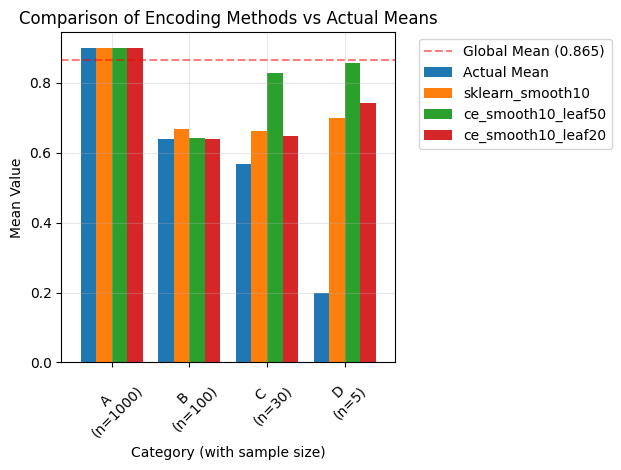

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison DataFrame including actual means
results = pd.DataFrame({
    'Actual Mean': target.groupby(data['category']).mean(),
    'sklearn_smooth10': pd.DataFrame(sk_encoded, columns=['encoded'], index=data.index)
                       .groupby(data['category'])['encoded'].mean(),
    'ce_smooth10_leaf50': ce_encoded2.groupby(data['category']).mean()['category'],
    'ce_smooth10_leaf20': ce_encoded3.groupby(data['category']).mean()['category']
})

# Calculate global mean
global_mean = target.mean()

# Create bar plot
plt.figure(figsize=(12, 6))
results.plot(kind='bar', width=0.8)

# Add horizontal line for global mean
plt.axhline(y=global_mean, color='r', linestyle='--', alpha=0.5, 
            label=f'Global Mean ({global_mean:.3f})')

plt.title('Comparison of Encoding Methods vs Actual Means')
plt.xlabel('Category (with sample size)')
plt.ylabel('Mean Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add sample sizes to x-labels
category_sizes = data['category'].value_counts().sort_index()
plt.xticks(range(len(category_sizes)), 
           [f'{cat}\n(n={size})' for cat, size in category_sizes.items()], 
           rotation=45)

plt.tight_layout()
plt.show()